In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp
import os
import scipy.optimize as optimization

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  




:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Problem description

### Model
$ y = I\,e^{-a\,x}\,\cos(b\,x) $

- There is no (sturctural) model uncertainty

### True parameters
$I = 10.$

$a = 0.2$

$b = 0.5$

### True input distribution
$p(x) = Weibull(A=2,k=10)$

### Input Measurement Distribution
$p(\tilde{x}|x) = Normal(\mu=x,\sigma_x)$

### Output Measurement Distribution
$p(\tilde{y}|y) = Normal(\mu=y,\sigma_y)$




In [2]:
def model(x,a,b,I):
    return I*np.exp(-a*x)*np.cos(b*x)

# Synthetica data

In [3]:
dist_x = cp.Weibull(shape=2., scale=12., shift=0)
sigma_x = 0.5
sigma_y = 2.0
dist_meas_x = cp.Normal(mu=0., sigma=sigma_x)
dist_meas_y = cp.Normal(mu=0., sigma=sigma_y) 

N_meas = 1000
x_true_sample = dist_x.sample(size=N_meas,rule='R')
y_true_sample = model(x_true_sample,a=.2,b=0.5,I=10.)

epsilon_x_sample = dist_meas_x.sample(size=N_meas,rule='R')
epsilon_y_sample = dist_meas_y.sample(size=N_meas,rule='R')

x_tilde = x_true_sample+epsilon_x_sample
y_tilde = y_true_sample+epsilon_y_sample

In [4]:
folder = 'Figures/b_Sx_'+str(sigma_x).replace('.','p')+'_Sy_'+str(sigma_y).replace('.','p')+'/'
if not os.path.exists(folder): os.mkdir(folder)

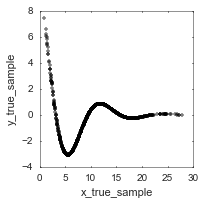

In [5]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(x_true_sample,y_true_sample,'.k',alpha=0.5)
ax.set_xlabel('x_true_sample')
ax.set_ylabel('y_true_sample')

fig.tight_layout()
fig.savefig(folder+'b_xy_true.pdf')
print

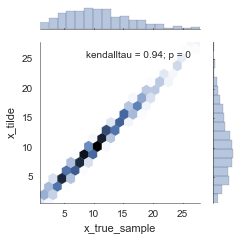

In [6]:
fig=sns.jointplot(
    x_true_sample,
    x_tilde, 
    kind="hex", 
    stat_func=stats.kendalltau,
    size=3.5
    )

fig.set_axis_labels('x_true_sample','x_tilde')
fig = plt.gcf()
fig.tight_layout()
fig.savefig(folder+'b_x_true_x_tilde.pdf')
print

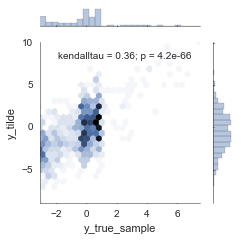

In [7]:
fig=sns.jointplot(
    y_true_sample,
    y_tilde, 
    kind="hex", 
    stat_func=stats.kendalltau,
    size=3.5
    )

fig.set_axis_labels('y_true_sample','y_tilde')
fig = plt.gcf()
fig.tight_layout()
fig.savefig(folder+'b_y_true_y_tilde.pdf')
print

In [8]:
bins_x=np.arange(-0.5,31,1.)
n_bin = stats.binned_statistic(x=x_tilde, values=x_tilde, statistic='count', bins=bins_x)[0]
x_tilde_bin_E = stats.binned_statistic(x=x_tilde, values=x_tilde, statistic='mean', bins=bins_x)[0]
x_tilde_bin_S = stats.binned_statistic(x=x_tilde, values=x_tilde, statistic=stats.sem, bins=bins_x)[0]
y_tilde_bin_E = stats.binned_statistic(x=x_tilde, values=y_tilde, statistic='mean', bins=bins_x)[0]
y_tilde_bin_S = stats.binned_statistic(x=x_tilde, values=y_tilde, statistic=stats.sem, bins=bins_x)[0]

n_bin_min = 5
x_tilde_bin_E = x_tilde_bin_E[n_bin>n_bin_min]
x_tilde_bin_S = x_tilde_bin_S[n_bin>n_bin_min]
y_tilde_bin_E = y_tilde_bin_E[n_bin>n_bin_min]
y_tilde_bin_S = y_tilde_bin_S[n_bin>n_bin_min]

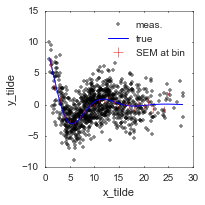

In [9]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(x_tilde,y_tilde,'.k',alpha=0.5, label='meas.')
ax.errorbar(x_tilde_bin_E, y_tilde_bin_E, yerr=y_tilde_bin_S, xerr=x_tilde_bin_S, 
            color='r',barsabove=True,linewidth=0,elinewidth=1.,alpha=0.5,zorder=100, label='SEM at bin')
ax.plot(np.sort(x_true_sample),model(np.sort(x_true_sample),a=0.2,b=0.5,I=10.),'-b',lw=1,zorder=99, label='true')
ax.set_xlabel('x_tilde')
ax.set_ylabel('y_tilde')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig(folder+'b_xy_tilde.pdf')
print

# a1) Bayesian inference ussing PCE. 

### Prior parameters
$I = 10.$

$a = Uniform[0.1,0.3]$ 

$b = Uniform[0.4,0.6]$

In [70]:
prior_a = cp.Uniform(0.1,0.3)#cp.Normal(0.15,0.1)#
prior_b = cp.Uniform(0.4,0.6)#cp.Normal(0.35,0.1)#

prior = cp.J(prior_a,prior_b)

sigma_x_Bayes = 0.5
sigma_y_Bayes = 2.0
dist_meas_x_Bayes = cp.Normal(mu=0., sigma=sigma_x_Bayes) 
dist_meas_y_Bayes = cp.Normal(mu=0., sigma=sigma_y_Bayes) 

In [71]:
label = 'SxB_'+str(sigma_x_Bayes).replace('.','p')\
      +'_SyB_'+str(sigma_y_Bayes).replace('.','p')
folder_inner = folder+label+'/'
if not os.path.exists(folder_inner): os.mkdir(folder_inner)

In [72]:
def f(x,a,b,i):
    return dist_meas_x_Bayes.pdf(x_tilde[i]-x)*dist_meas_y_Bayes.pdf(y_tilde[i]-model(x,a,b,I=10.))

Discretizetion of the parameter space

In [73]:
N_eval = 1000
theta_eval = prior.sample(N_eval,rule='M')

### PCE with respect pdf(x)

In [74]:
# Uncorrelated Standard Normals
dist_R = cp.J(cp.Uniform())

In [75]:
M = 5    # Order of the polynomial
N = M + 1 # Number of terms, evaluations per dimension

In [76]:
# Polynomial for Uniform: 
P = cp.orth_ttr(M, dist_R)

In [82]:
# Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]

# Exponenial rule 
# nodes_R = dist_R.sample(2**M-1,rule='M') 

# Fixed number of nodes
nodes_R = dist_R.sample(40,rule='M') 
nodes = dist_x.inv(dist_R.fwd(nodes_R))

N_cal = 1000
ind_nonvalid =[]
E_x_f = np.ones([N_eval,N_cal])
for i in range(N_cal):
    sample_y_nodes = np.array([f(node,a=theta_eval[0,:],b=theta_eval[1,:],i=i) for node in nodes.T])
    f_hat = cp.fit_regression(P, nodes_R, sample_y_nodes)
    E_x_f_i = cp.E(f_hat, dist_R)
    C_ = np.mean(E_x_f_i)
    if  (C_>2e-3):#1e-5):
        E_x_f[:,i] = E_x_f_i/C_
    else:
        ind_nonvalid.append(i)
        E_x_f[:,i] = np.ones_like(E_x_f_i)

In [83]:
N_tilde = N_cal #1000

ind = [i for i in range(N_cal) if i not in ind_nonvalid]

post = prior.pdf(theta_eval)
for i in ind:
    if (i not in ind_nonvalid)&(i<N_tilde):
        post_old = post
        post = E_x_f[:,i]*post_old

        C_ = np.mean(post)
        if  (C_>0):
            post = post/C_
        else:
            ind_nonvalid.append(i)
            post = post_old

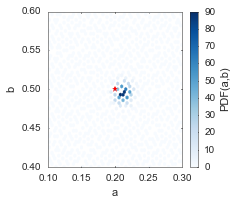

In [84]:
fig = plt.figure(figsize=[3.4,3])
ax = fig.add_subplot(111)
#cm=ax.hexbin(x=theta_eval[0,:],y=theta_eval[1,:],C=prior.pdf(theta_eval),cmap=plt.cm.Blues, gridsize=30)
cm=ax.hexbin(x=theta_eval[0,:],
             y=theta_eval[1,:],
             C=post,
             cmap=plt.cm.Blues, 
             gridsize=50,
             vmin=0,
             #vmax=100
            )
ax.plot(0.2,0.5,'*r')
ax.set_xlabel('a')
ax.set_ylabel('b')
cb=fig.colorbar(cm)
cb.set_label('PDF(a,b)')
#cb.set_ticks([])
fig.tight_layout()
fig.savefig(folder_inner+'b_post_N_tilde_'+str(N_tilde)+'_prior_sample.pdf')
print

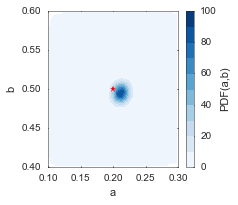

In [85]:
a_mg,b_mg = np.meshgrid(np.linspace(0.1,0.3,100),np.linspace(0.4,0.6,100))
resampled = mpl.mlab.griddata(theta_eval[0,:],theta_eval[1,:],post, a_mg, b_mg, interp='nn')
levels=np.arange(0,110,10) 

fig = plt.figure(figsize=[3.4,3])
ax = fig.add_subplot(111)
cm=ax.contourf(a_mg,b_mg,resampled,cmap=plt.cm.Blues, levels=levels ) 
ax.plot(0.2,0.5,'*r')
ax.set_xlabel('a')
ax.set_ylabel('b')
cb=fig.colorbar(cm)
cb.set_label('PDF(a,b)')
#cb.set_ticks([])
fig.tight_layout()
fig.savefig(folder_inner+'b_post_N_tilde_'+str(N_tilde)+'.pdf')
fig.savefig(folder+'b_post_'+label+'.pdf')
#fig.savefig(folder+'a_post_'+'SEM'+'.pdf')
print


Non valid =  119


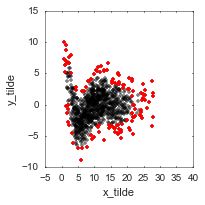

In [86]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(x_tilde,y_tilde,'.k',alpha=0.5)
ax.plot(x_tilde[ind_nonvalid],y_tilde[ind_nonvalid],'.r')
#ax.plot(x_tilde_bin_E[ind_nonvalid],y_tilde_bin_E[ind_nonvalid],'.r')
ax.set_xlabel('x_tilde')
ax.set_ylabel('y_tilde')
ax.set_xlim([-5,40])
fig.tight_layout()
fig.savefig(folder+'b_xy_tilde_non_informative_'+label+'.pdf')
print 'Non valid = ', len(ind_nonvalid)

In [22]:
def f_SEM(x,a,b,i):
    return cp.Normal(mu=0., sigma=x_tilde_bin_S[i]).pdf(x_tilde_bin_E[i]-x)\
          *cp.Normal(mu=0., sigma=y_tilde_bin_S[i]).pdf(y_tilde_bin_E[i]-model(x,a,b,I=10.))

In [34]:
# Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]

# Exponenial rule 
# nodes_R = dist_R.sample(2**M-1,rule='M') 

# Fized number of nodes
nodes_R = dist_R.sample(30,rule='M') 
nodes = dist_x.inv(dist_R.fwd(nodes_R))

N_cal = len(y_tilde_bin_E)
ind_nonvalid =[]
E_x_f_SEM = np.ones([N_eval,N_cal])
for i in range(N_cal):
    sample_y_nodes = np.array([f_SEM(node,a=theta_eval[0,:],b=theta_eval[1,:],i=i) for node in nodes.T])
    y_hat = cp.fit_regression(P, nodes_R, sample_y_nodes)
    E_x_f_i = cp.E(y_hat, dist_R)
    C_ = np.mean(E_x_f_i)
    if  (C_>0):
        E_x_f_SEM[:,i] = E_x_f_i/C_
    else:
        ind_nonvalid.append(i)
        E_x_f_SEM[:,i] = np.ones_like(E_x_f_i)

In [35]:
N_tilde = N_cal 

ind = [i for i in range(N_cal) if i not in ind_nonvalid]

post_SEM = prior.pdf(theta_eval)
for i in ind:
    if (i not in ind_nonvalid)&(i<N_tilde):
        post_old = post_SEM
        post_SEM = E_x_f_SEM[:,i]*post_old

        C_ = np.mean(post_SEM)
        if  (C_>0):
            post_SEM = post_SEM/C_
        else:
            ind_nonvalid.append(i)
            post_SEM = post_a_old

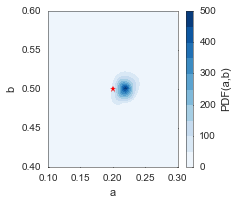

In [63]:
a_mg,b_mg = np.meshgrid(np.linspace(0.1,0.3,100),np.linspace(0.4,0.6,100))
resampled = mpl.mlab.griddata(theta_eval[0,:],theta_eval[1,:],post_SEM, a_mg, b_mg, interp='nn')
levels=np.arange(0,530,50) 

fig = plt.figure(figsize=[3.4,3])
ax = fig.add_subplot(111)
cm=ax.contourf(a_mg,b_mg,resampled,cmap=plt.cm.Blues, levels=levels ) 
ax.plot(0.2,0.5,'*r')
ax.set_xlabel('a')
ax.set_ylabel('b')
cb=fig.colorbar(cm)
cb.set_label('PDF(a,b)')
#cb.set_ticks([])
fig.tight_layout()
#fig.savefig(folder_inner+'b_post_N_tilde_'+str(N_tilde)+'.pdf')
#fig.savefig(folder+'b_post_'+label+'.pdf')
fig.savefig(folder+'a_post_'+'bin'+'.pdf')
print



In [47]:
def model_LSQfit(x,a,b):
    I=10.
    return I*np.exp(-a*x)*np.cos(b*x)

In [48]:
LSQ = optimization.curve_fit(model_LSQfit, x_tilde, y_tilde, p0=[0.2,0.3], sigma=sigma_y_Bayes)
print LSQ[0]
print LSQ[1]

[ 0.21645239  0.4956829 ]
[[  7.07106112e-05   5.57666665e-06]
 [  5.57666665e-06   6.59024451e-05]]


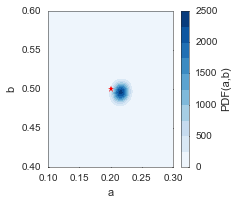

In [62]:
a_mg,b_mg = np.meshgrid(np.linspace(0.1,0.3,100),np.linspace(0.4,0.6,100))
resampled = cp.MvNormal(LSQ[0],LSQ[1]).pdf([a_mg.flatten(), b_mg.flatten()]).reshape(a_mg.shape)
levels=np.arange(0,2600,250) 

fig = plt.figure(figsize=[3.4,3])
ax = fig.add_subplot(111)
cm=ax.contourf(a_mg,b_mg,resampled,cmap=plt.cm.Blues, levels=levels ) 
ax.plot(0.2,0.5,'*r')
ax.set_xlabel('a')
ax.set_ylabel('b')
cb=fig.colorbar(cm)
cb.set_label('PDF(a,b)')
#cb.set_ticks([])
fig.tight_layout()
#fig.savefig(folder_inner+'b_post_N_tilde_'+str(N_tilde)+'.pdf')
#fig.savefig(folder+'b_post_'+label+'.pdf')
fig.savefig(folder+'a_post_'+'LSQ'+'.pdf')
print

